<a href="https://colab.research.google.com/github/nicoleluo7/info1998-final/blob/main/info1998.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO1998 Final Project: Nicole Luo, Anna Sahakyan, Andelo Vrdoljak


## Topic

Predicting whether a student is dealing with major depressive disorder (MDD) and identifying the greatest contributors of MDD.


# Introduction

Major Depressive Disorder (MDD), or more commonly known as just depression, is a mood disorder characterized by a higher than usual loss of interest and sadness. It is one of the leading illnesses with higher mortality rates in youth and adolescence, and furthermore, approximately 29% of the population being once diagnosed with depression at some point in life. That being said, understanding the factors that contribute to the development of depression is essential for early detection and intervention. The main focus of this research is to analyze a spectrum of different variables that might cause depression in youth such as academic, personal, or even lifestyle factors with hopes of identifying greatest contributors, as well as predicting whether a student is suffering with depression in the first place.

## Background Information and Sources

As previously mentioned, depression is a serious mental health condition that negatively affects many individuals in the society. Depression can occur at any point in life, on average, it can first appear during late teens to mid 20's, the time of many changes, hard decisions, and stressful academic pathways.

Common symptoms include, but are not limited to:
1. Feeling sad, hopeless, or empty.
2. Loosing interest in things you cared.
3. Change in appetite.
4. Decreased energy, or higher feeling of tiredness.
5. Change in sleep schedule, both less or more sleep.
6. Feeling worthless or guilty.
7. Difficulty concentrating, and difficulty regarding making decisions.
8. Thoughts of death.

Given the higher prevalence of depression diagnozations in adolescent years and early adulthood, early identification and prevention is essential. This research aims to help in this by building predictive models to identify students who are suffering from MDD and to uncover the factors that contribute the most in the development of MDD.

In this research, we have used "Student Depression Dataset: Analyzing Mental Health Trends and Predictors Among Students" found on Kaggle. This dataset compiled a wide range of information aimed at understanding, analyzing, and predicting depression levels among students. It is updated recently by the authors of the dataset, with the last update before writing this research being in March, 2025.

**Dataset**: https://www.kaggle.com/datasets/adilshamim8/student-depression-dataset

**Information regarding depression**: https://www.psychiatry.org/patients-families/depression/what-is-depression



# Hypothesis

**Hypothesis**: Academic pressure, history of suicidal thoughts, and study satisfaction are the greatest contributors of depression among students and adolescents.

# Variables

**Independent Variables**

Independent variables chosen from this dataset were chosen based on the probable significance they may have when it comes to causation of the depression. They represent a spectrum of academic, lifesyle, psychological, and personal factors.
1. Gender
2. Age
3. Academic Pressure
4. Work Pressure
5. CGPA
6. Study Satisfaction
7. Job Satisfaction
8. Sleep Duration
9. Dietary Habits
10. History of Previous Suicidal Thoughts

**Dependent Variable**

The only independent variable in this research is depression which we aimed to predict using the above variables.

In [ ]:
from google.colab import drive

import pandas as pd
from sklearn.impute import SimpleImputer
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/ColabData/student_depression_dataset.csv")

# Seeing which columns are non-numeric
obj_cols = df.select_dtypes(include='object').columns.tolist()

# Removing whitespace and single-quotes from all object columns
for col in obj_cols:
    df[col] = df[col].astype(str).str.strip().str.strip("'")

# Binary columns (Yes/No → 1/0)
binary_cols = [
    'Have you ever had suicidal thoughts ?',
    'Family History of Mental Illness'
]
# Numeric but stored as string columns
numeric_str_cols = ['Financial Stress']

# Multi-category columns (everything else that’s object)
multi_cols = [c for c in obj_cols if c not in binary_cols + numeric_str_cols]


# Converting binary columns to 0/1
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Turning “?” into NaN, then to floats, for Financial Stress
df['Financial Stress'] = pd.to_numeric(
    df['Financial Stress'].replace('?', pd.NA),
    errors='coerce'
)

# Mapping Sleep Duration to an ordinal scale
sleep_map = {
    'Less than 5 hours': 0,
    '5-6 hours':        1,
    '7-8 hours':        2,
    'More than 8 hours':3,
    'Others':           pd.NA
}
df['Sleep Duration'] = df['Sleep Duration'].map(sleep_map)

# Degree → Undergrad / Graduate / Doctoral / Other
undergrad = {'B.Pharm','BSc','BA','BCA','B.Ed','BE','BHM','B.Com','B.Arch','B.Tech','BBA','Class 12'}
graduate  = {'M.Tech','MSc','MA','M.Ed','MCA','M.Com','MBA','M.Pharm','ME','LLM'}
doctoral  = {'PhD','MD','MBBS'}
def map_degree(deg):
    if deg in undergrad:   return 'Undergraduate'
    if deg in graduate:    return 'Graduate'
    if deg in doctoral:    return 'Doctoral'
    return 'Other'
df['Degree_Group'] = df['Degree'].map(map_degree)

# City → Metro vs. Non-Metro
metro_cities = {
    'Delhi','Mumbai','Bangalore','Kolkata','Chennai','Hyderabad',
    'Ahmedabad','Pune','Surat','Jaipur','Lucknow','Kanpur'
}
def map_city(city):
    return 'Metro' if city in metro_cities else 'Non-Metro'
df['City_Type'] = df['City'].map(map_city)

# Defining groups for Profession → Education / Healthcare / Tech/Creative / Business / Other
edu      = {'Student','Teacher','Educational Consultant'}
health   = {'Doctor','Pharmacist'}
tech     = {'Civil Engineer','Architect','UX/UI Designer','Digital Marketer'}
business = {'Manager','Entrepreneur','Content Writer','Lawyer','Chef'}
def map_profession(p):
    if p in edu:      return 'Education'
    if p in health:   return 'Healthcare'
    if p in tech:     return 'Tech/Creative'
    if p in business: return 'Business'
    return 'Other'
df['Profession_Group'] = df['Profession'].map(map_profession)

# Encoding Dietary Habits as an ordinal score
diet_map = {'Unhealthy': 0, 'Moderate': 1, 'Healthy': 2, 'Others': pd.NA}
df['Dietary_Habit_Score'] = df['Dietary Habits'].map(diet_map)

# Dropping original high-card columns as we no longer need them
df.drop(columns=['Degree','City','Profession','Dietary Habits'], inplace=True)

# Mapping Gender → Male/Female to 1/0
if 'Gender' in df.select_dtypes(include='object').columns:
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# Converting 'Sleep Duration' & 'Dietary_Habit_Score' to numeric and imputing missing values
df['Sleep Duration']      = pd.to_numeric(df['Sleep Duration'], errors='coerce')
df['Dietary_Habit_Score'] = pd.to_numeric(df['Dietary_Habit_Score'], errors='coerce')

# Filling in the NaNs with the medians
imp = SimpleImputer(strategy='median')
for col in ['Sleep Duration','Financial Stress','Dietary_Habit_Score']:
    df[[col]] = imp.fit_transform(df[[col]])

# One-hot encoding the grouped columns: Degree_Group, City_Type, Profession_Group
df = pd.get_dummies(
    df,
    columns=['Degree_Group','City_Type','Profession_Group'],
    drop_first=True
)

# Converting boolean columns to integers
bool_cols = df.select_dtypes(include='bool').columns.tolist()
for c in bool_cols:
    df[c] = df[c].astype(int)

df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Have you ever had suicidal thoughts ?,...,Family History of Mental Illness,Depression,Dietary_Habit_Score,Degree_Group_Graduate,Degree_Group_Other,Degree_Group_Undergraduate,City_Type_Non-Metro,Profession_Group_Education,Profession_Group_Healthcare,Profession_Group_Tech/Creative
0,2,1,33.0,5.0,0.0,8.97,2.0,0.0,1.0,1,...,0,1,2.0,0,0,1,1,1,0,0
1,8,0,24.0,2.0,0.0,5.90,5.0,0.0,1.0,0,...,1,0,1.0,0,0,1,0,1,0,0
2,26,1,31.0,3.0,0.0,7.03,5.0,0.0,0.0,0,...,1,0,2.0,0,0,1,1,1,0,0
3,30,0,28.0,3.0,0.0,5.59,2.0,0.0,2.0,1,...,1,1,1.0,0,0,1,1,1,0,0
4,32,0,25.0,4.0,0.0,8.13,3.0,0.0,1.0,1,...,0,0,1.0,1,0,0,0,1,0,0
5,33,1,29.0,2.0,0.0,5.70,3.0,0.0,0.0,0,...,0,0,2.0,0,0,0,0,1,0,0
6,52,1,30.0,3.0,0.0,9.54,4.0,0.0,2.0,0,...,0,0,2.0,0,0,1,1,1,0,0
7,56,0,30.0,2.0,0.0,8.04,4.0,0.0,0.0,0,...,1,0,0.0,0,0,1,0,1,0,0
8,59,1,28.0,3.0,0.0,9.79,1.0,0.0,2.0,1,...,0,1,1.0,0,0,1,1,1,0,0
9,62,1,31.0,2.0,0.0,8.38,3.0,0.0,0.0,1,...,0,1,1.0,0,1,0,1,1,0,0


Summary of what was done in this data cleaning and imputation step:
- Stripped extra whitespace and stray quotes from all string columns
- Mapped binary “Yes/No” fields to 1/0
- Converted Financial Stress to numeric (handled “?” as NaN)
- Ordinal-encoded Sleep Duration (0–3) and Dietary Habits (0–2)
- Grouped high-cardinality fields:
    • Degree → Undergraduate/Graduate/Doctoral/Other
    • City → Metro vs. Non-Metro
    • Profession → Education/Healthcare/Tech-Creative/Business/Other
- Dropped original string columns after recoding
- Converted Gender to 1 (Male), 0 (Female)
- Imputed remaining NaNs with feature medians
- One‑hot‑encoded grouped categories (dropped first level)
- Cast boolean flags to integers

Our data is now fully numeric with no missing values.

# Data Visualization



Firstly, we will make a bar graph for a number of features we are interested in. The bar graph will show average values across the features which is quite useful when evaluating the significance of each distinct features.

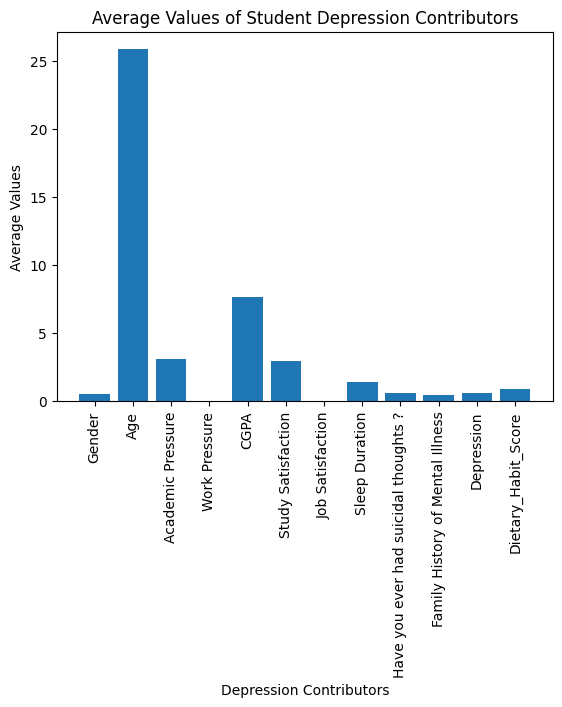

In [ ]:
import matplotlib.pyplot as plt
# Selecting desired features that will be included in the bar graph.
features = ['Gender', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
            'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
            'Have you ever had suicidal thoughts ?',
            'Family History of Mental Illness', 'Depression',
            'Dietary_Habit_Score']
selected_features = df[features]
# Calculating the mean.
mean = selected_features.mean()

# Bar creation and manipulation.
plt.bar(mean.index, mean, align='center')
plt.title('Average Values of Student Depression Contributors')
plt.ylabel('Average Values')
plt.xlabel('Depression Contributors')
plt.xticks(rotation=90)

# Finally, show().
plt.show()

In order to help answer the research question, it was quite convenient to include the correlation plot between the features of the dataset and whether an individual had depression previously. This way, one may conclude how strongly/weakly are these features positively or negatively correlated with depression. Said differently, the higher the magnitude of the correlation, the greater the contributor of MDD. Additionally, it is worth noting that statistically speaking, the correlation between two variables may not be a proof of causation, however, the chosen features are usually deemed as causations of depression.

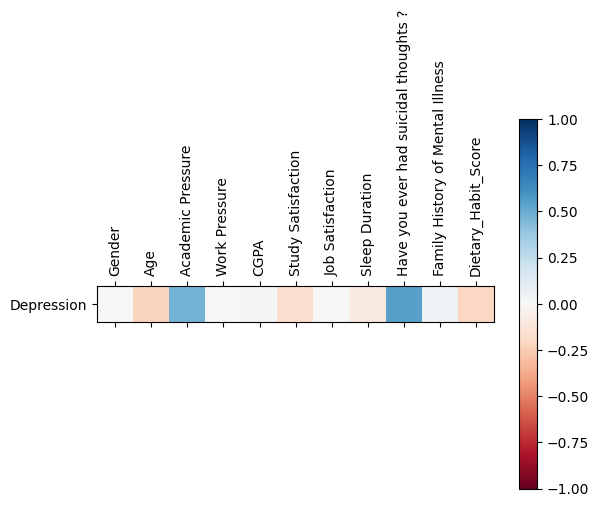

In [ ]:
# Selecting desired features that will be included in the correlation map.
features = ['Gender', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
            'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
            'Have you ever had suicidal thoughts ?',
            'Family History of Mental Illness', 'Depression',
            'Dietary_Habit_Score']
selected_features = df[features]

# The "y-axis" of this correlation map will be the depression feature, whereas
# the "x-axis" will hold the rest of the chosen features, thus enabling us
# to see how correlated are these features with MDD.
X = selected_features.drop(columns=['Depression'])
Y = selected_features['Depression']
correlation = pd.DataFrame(X.corrwith(Y), columns=['Correlation'])

# Creating a figure instance.
fig = plt.figure()
# Adding a subplot to plot on.
ax = fig.add_subplot(111)
fig.colorbar(ax.matshow(correlation.T, cmap='RdBu', vmin=-1, vmax=1))

# X-axis feature modifications.
ax.set_xticks(range(len(correlation.index)))
ax.set_xticklabels(correlation.index)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
# Y-axis feature modifications.
ax.set_yticks([0])
ax.set_yticklabels(['Depression'])


# Finally, the show().
plt.show()





Result findings so far:
Based on the correlation map, variables with the highest positive relationship between being diagnosed with MDD are: academic pressure and history of suicidal thoughts. On the other hand, relatively weak negative relationship was shown in age, study satisfaction, and dietary habit features. The rest of the variables did not exhibit much correlation. The contribution of said variables will be further investigated.

#Models

#Model 1: Logistic Regression Classifier

To begin modeling, we first implemented a Logistic Regression classifier to predict whether a student is dealing with major depressive disorder (MDD). Logistic regression is a simple yet powerful model well-suited for binary classification problems like this one. To prepare the data, we used scikit-learn's train_test_split for splitting into training and testing sets, and StandardScaler to normalize feature values for better model performance. We built the model using LogisticRegression from scikit-learn, and evaluated it with accuracy_score and classification_report tools.

In [ ]:
# Imports
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate features and target
target_column = 'Depression'
X = df.drop(columns=[target_column])
y = df[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Feature Scaling (good for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)

# Metrics
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Results:
Accuracy: 0.8372993119266054
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      2915
           1       0.85      0.88      0.86      4061

    accuracy                           0.84      6976
   macro avg       0.83      0.83      0.83      6976
weighted avg       0.84      0.84      0.84      6976



##Interpreting Results

The logistic regression model achieved an overall accuracy of 83.7%. The model demonstrated strong performance in both identifying students with MDD and students without MDD, with precision and recall values above 78% for both classes. It was slightly better at detecting students with MDD (88% recall) compared to students without MDD (78% recall). Another metric we used to inerpret our results is the F1-score, which is the harmonic mean of precision and recall; a higher F1-score indicates a better balance between correctly predicting positive cases and minimizing false positives. The F1-scores were well-balanced between the two classes, suggesting that the model maintains a good tradeoff between precision and recall. Overall, the logistic regression model serves as an effective and reliable baseline for predicting student depression.

##Model 2: Random Forest Classifier

To build a second model that might yield a higher accuracy, we implemented a Random Forest Classifier. Random Forest is an ensemble method that creates multiple decision trees and combines their outputs to improve prediction accuracy and reduce overfitting. Unlike logistic regression, random forests do not require feature scaling. We used scikit-learn's RandomForestClassifier to build the model, and evaluated its performance using accuracy_score and classification_report, similar to the previous model. Additionally, we used feature importance analysis to better understand which features contribute most significantly to the predictions.


Random Forest Results:
Accuracy: 0.83049632682315
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      2343
           1       0.85      0.87      0.86      3238

    accuracy                           0.83      5581
   macro avg       0.83      0.82      0.83      5581
weighted avg       0.83      0.83      0.83      5581



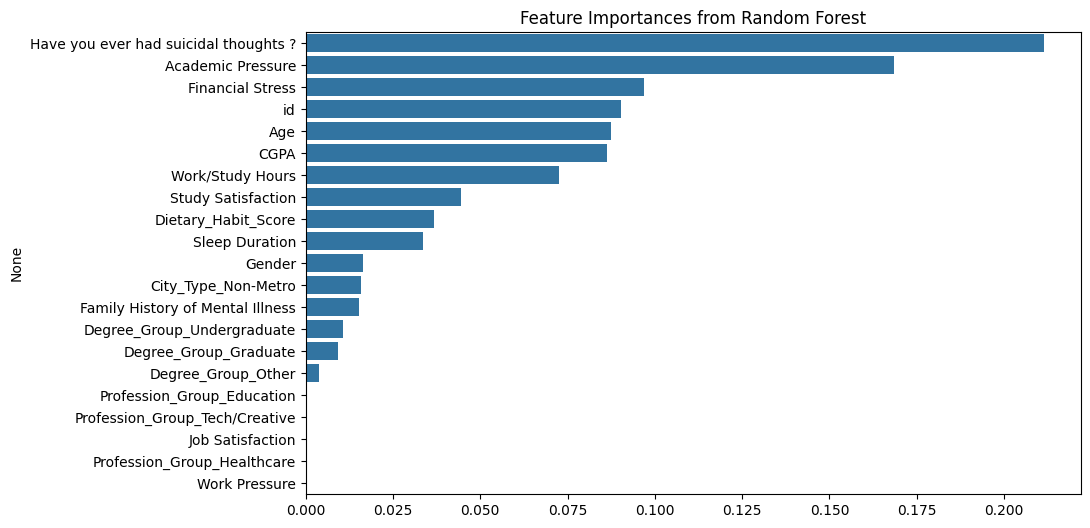

In [ ]:
# -----------------
# Model 2: Random Forest
# -----------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Metrics
print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Feature Importance Visualization
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title('Feature Importances from Random Forest')
plt.show()

##Interpreting Results

The Random Forest model demonstrated strong performance, achieving an overall accuracy of 83.05%. Like the logistic regression model, it showed balanced precision and recall across both classes, successfully identifying students both with and without MDD. Importantly, we evaluated the model using the F1-score, which is the harmonic mean of precision and recall; a higher F1-score indicates a better balance between correctly predicting positive cases and minimizing false positives.

The model also provided insights into feature importance, allowing us to better identify the strongest contributors to major depressive disorder among students. We can see that the top 3 features contributing to MDD are presence of suicidal thoughts, academic pressure, and financial stress.

##Tuning: using GridSearchCV

GridSearchCV is a machine learning technique that helps find the best hyperparameters for a model by systematically trying different combinations of parameter values. It performs cross-validation for each combination to determine which settings give the best performance on unseen data.

We decided to use GridSearchCV for the Random Forest model to optimize its performance and ensure that we were using the best possible configuration of parameters like the number of trees, tree depth, and minimum samples per split.


In [ ]:
# Imports
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10]
}


# Create base model
rf = RandomForestClassifier(random_state=42)

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,               # 3-fold cross-validation
    n_jobs=-1,          # use all CPU cores
    verbose=2           # show progress
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after tuning
best_rf = grid_search.best_estimator_

# Predict with tuned model
y_pred_best_rf = best_rf.predict(X_test)

# Evaluation
print("Tuned Random Forest Results:")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tuned Random Forest Results:
Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.8317505823329152
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      2343
           1       0.84      0.87      0.86      3238

    accuracy                           0.83      5581
   macro avg       0.83      0.82      0.83      5581
weighted avg       0.83      0.83      0.83      5581



After applying hyperparameter tuning with GridSearchCV, the Random Forest model's accuracy increased slightly from 83.05% to 83.17%. This small improvement suggests that the original model was already relatively well-suited to the dataset. Nevertheless, tuning helped slightly optimize model performance and confirmed that Random Forest remains a strong predictive model for our problem, though still losing to the logistic regression model slightly.

#Conclusion

Surprisingly, the simpler Logistic Regression model achieved slightly higher accuracy than the more flexible Random Forest. This indicates that the relationship between our features and MDD status is **largely linear and additive**—Logistic Regression’s decision boundary was already well-aligned with the true separation in the data. In turn, this revealed that complex feature interactions (which Random Forests specialize in) are less critical here than straightforward, scaled predictors. It is also worth noting that logistic regression is the more computationally efficient model of the two.

#Implications

Our model highlights that high academic pressure, poor sleep habits, and financial stress are the strongest predictors of student depression, which matters because it could potentially tell us exactly where to focus support and prevention efforts. By identifying these key factors, universities could proactively offer time-management resources and sleep-health workshops. Counselors could design targeted programs for students struggling with money worries. Knowing which habits most affect mental health also empowers students to adjust their routines and seek help before problems escalate. Moreover, these insights guide administrators in crafting policies, like emergency funding or adjusted deadlines, that address root causes rather than symptoms. So, understanding the biggest drivers of depression allows everyone involved to take smarter and more effective steps toward keeping students well.